# Comprehensive Model Comparison
## Comparing all models across all preprocessing strategies
### Metrics: AUROC, PR AUC, Recall at various thresholds

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import (
    roc_auc_score, average_precision_score, recall_score,
    precision_recall_curve, roc_curve, f1_score, accuracy_score
)
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

## 1. Load All Results

In [2]:
# Load results from all models
models = ['logistic_regression', 'lightgbm', 'dnn']
model_display_names = {
    'logistic_regression': 'Logistic Regression',
    'lightgbm': 'LightGBM',
    'dnn': 'Deep Neural Network'
}

all_results = {}
for model in models:
    try:
        df = pd.read_csv(f'model_results/{model}_results.csv')
        df['Model'] = model_display_names[model]
        all_results[model] = df
        print(f"Loaded {model} results: {df.shape}")
    except FileNotFoundError:
        print(f"Warning: {model}_results.csv not found. Run the corresponding model notebook first.")

if len(all_results) == 0:
    print("\nNo results found. Please run the model notebooks (05, 06, 07) first.")
else:
    # Combine all results
    combined_results = pd.concat([df for df in all_results.values()], ignore_index=True)
    print(f"\nCombined results shape: {combined_results.shape}")

Loaded logistic_regression results: (4, 8)
Loaded lightgbm results: (4, 8)
Loaded dnn results: (4, 8)

Combined results shape: (12, 8)


## 2. Overall Comparison Table

In [3]:
print("="*100)
print("COMPREHENSIVE MODEL COMPARISON - ALL PREPROCESSING STRATEGIES")
print("="*100)
print("\n")
print(combined_results.to_string(index=False))
print("\n" + "="*100)

COMPREHENSIVE MODEL COMPARISON - ALL PREPROCESSING STRATEGIES


            Strategy    AUROC   PR AUC  Recall (default)  Recall @0.3  Recall @0.5  Recall @0.7               Model
Simple (Median/Mode) 0.970370 0.888359          0.997289     1.000000     0.997289     0.949842 Logistic Regression
      KNN Imputation 0.965537 0.867804          0.992770     0.999548     0.992770     0.944871 Logistic Regression
     MICE Imputation 0.967849 0.869962          0.994577     0.999548     0.994577     0.947131 Logistic Regression
     Domain-Informed 0.978857 0.936482          0.994126     1.000000     0.994126     0.964754 Logistic Regression
Simple (Median/Mode) 1.000000 1.000000          1.000000     1.000000     1.000000     1.000000            LightGBM
      KNN Imputation 0.999046 0.996889          0.000000     1.000000     0.000000     0.000000            LightGBM
     MICE Imputation 1.000000 1.000000          1.000000     1.000000     1.000000     1.000000            LightGBM
     Dom

## 3. Best Model by Metric

In [4]:
metrics = ['AUROC', 'PR AUC', 'Recall (default)', 'Recall @0.3', 'Recall @0.5', 'Recall @0.7']

print("\n" + "="*80)
print("BEST PERFORMING MODEL-STRATEGY COMBINATIONS BY METRIC")
print("="*80)

best_performers = []
for metric in metrics:
    best_idx = combined_results[metric].idxmax()
    best_row = combined_results.iloc[best_idx]
    
    print(f"\n{metric}:")
    print(f"  Model: {best_row['Model']}")
    print(f"  Preprocessing: {best_row['Strategy']}")
    print(f"  Score: {best_row[metric]:.4f}")
    
    best_performers.append({
        'Metric': metric,
        'Model': best_row['Model'],
        'Strategy': best_row['Strategy'],
        'Score': best_row[metric]
    })

best_performers_df = pd.DataFrame(best_performers)
print("\n" + "="*80)


BEST PERFORMING MODEL-STRATEGY COMBINATIONS BY METRIC

AUROC:
  Model: LightGBM
  Preprocessing: Simple (Median/Mode)
  Score: 1.0000

PR AUC:
  Model: LightGBM
  Preprocessing: Simple (Median/Mode)
  Score: 1.0000

Recall (default):
  Model: LightGBM
  Preprocessing: Simple (Median/Mode)
  Score: 1.0000

Recall @0.3:
  Model: Logistic Regression
  Preprocessing: Simple (Median/Mode)
  Score: 1.0000

Recall @0.5:
  Model: LightGBM
  Preprocessing: Simple (Median/Mode)
  Score: 1.0000

Recall @0.7:
  Model: LightGBM
  Preprocessing: Simple (Median/Mode)
  Score: 1.0000



## 4. Visualization - AUROC Comparison

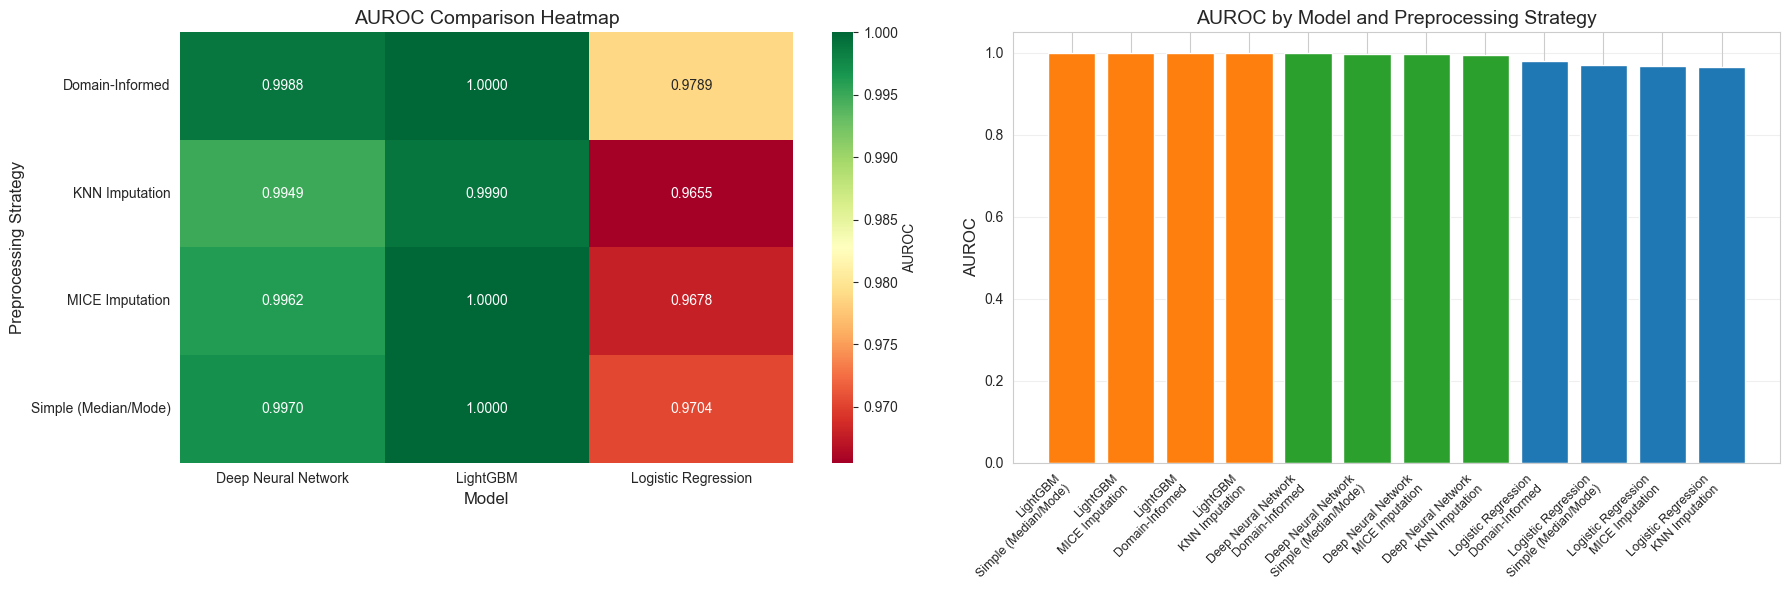

In [5]:
# Create pivot table for heatmap
auroc_pivot = combined_results.pivot(index='Strategy', columns='Model', values='AUROC')

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap
sns.heatmap(auroc_pivot, annot=True, fmt='.4f', cmap='RdYlGn', 
            vmin=auroc_pivot.min().min(), vmax=auroc_pivot.max().max(),
            ax=axes[0], cbar_kws={'label': 'AUROC'})
axes[0].set_title('AUROC Comparison Heatmap', fontsize=14)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Preprocessing Strategy', fontsize=12)

# Bar plot
combined_results_sorted = combined_results.sort_values('AUROC', ascending=False)
x_labels = [f"{row['Model']}\n{row['Strategy']}" for _, row in combined_results_sorted.iterrows()]
colors = ['#1f77b4' if 'Logistic' in label else '#ff7f0e' if 'LightGBM' in label else '#2ca02c' 
          for label in x_labels]

axes[1].bar(range(len(combined_results_sorted)), combined_results_sorted['AUROC'], color=colors)
axes[1].set_xticks(range(len(combined_results_sorted)))
axes[1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
axes[1].set_ylabel('AUROC', fontsize=12)
axes[1].set_title('AUROC by Model and Preprocessing Strategy', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_auroc.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Visualization - PR AUC Comparison

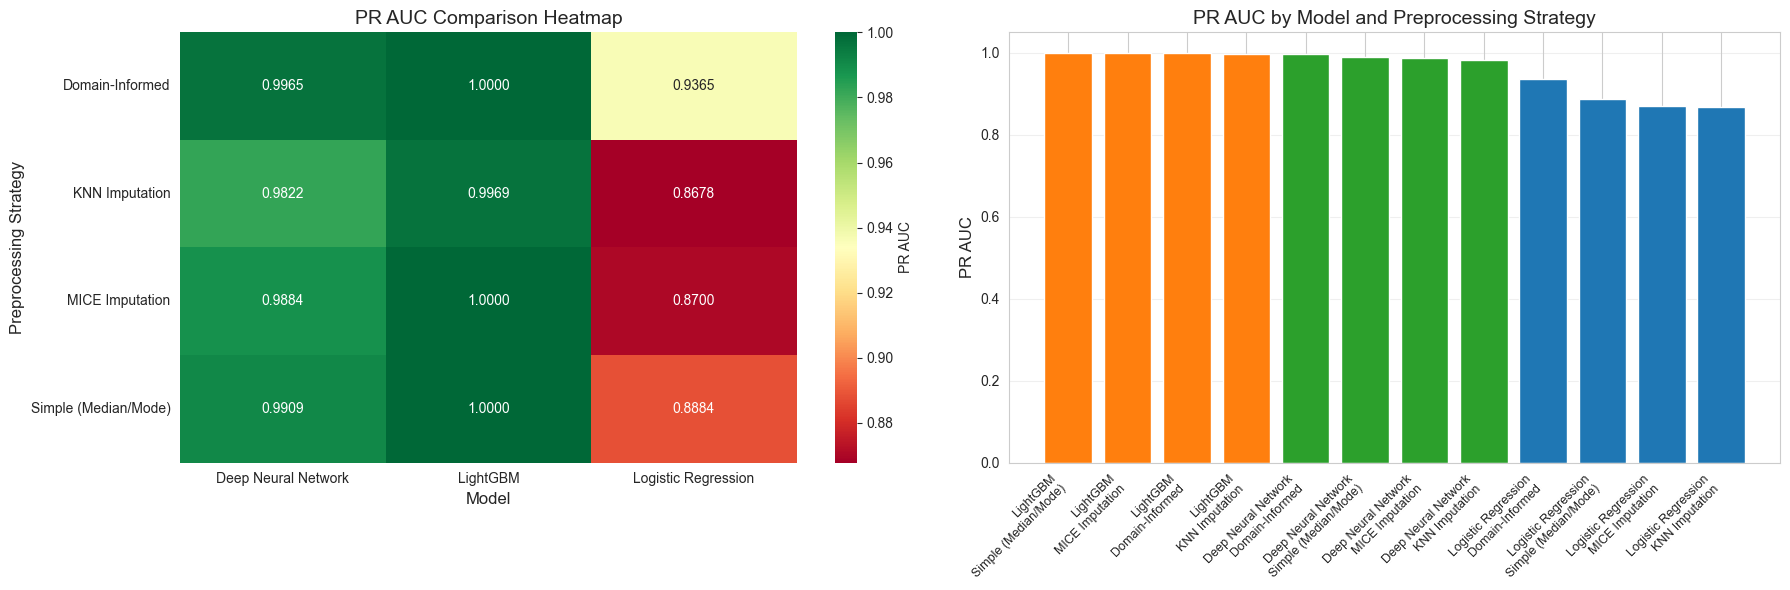

In [6]:
# PR AUC comparison
pr_auc_pivot = combined_results.pivot(index='Strategy', columns='Model', values='PR AUC')

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Heatmap
sns.heatmap(pr_auc_pivot, annot=True, fmt='.4f', cmap='RdYlGn',
            vmin=pr_auc_pivot.min().min(), vmax=pr_auc_pivot.max().max(),
            ax=axes[0], cbar_kws={'label': 'PR AUC'})
axes[0].set_title('PR AUC Comparison Heatmap', fontsize=14)
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Preprocessing Strategy', fontsize=12)

# Bar plot
combined_results_sorted = combined_results.sort_values('PR AUC', ascending=False)
x_labels = [f"{row['Model']}\n{row['Strategy']}" for _, row in combined_results_sorted.iterrows()]
colors = ['#1f77b4' if 'Logistic' in label else '#ff7f0e' if 'LightGBM' in label else '#2ca02c' 
          for label in x_labels]

axes[1].bar(range(len(combined_results_sorted)), combined_results_sorted['PR AUC'], color=colors)
axes[1].set_xticks(range(len(combined_results_sorted)))
axes[1].set_xticklabels(x_labels, rotation=45, ha='right', fontsize=9)
axes[1].set_ylabel('PR AUC', fontsize=12)
axes[1].set_title('PR AUC by Model and Preprocessing Strategy', fontsize=14)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_pr_auc.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Visualization - Recall at Different Thresholds

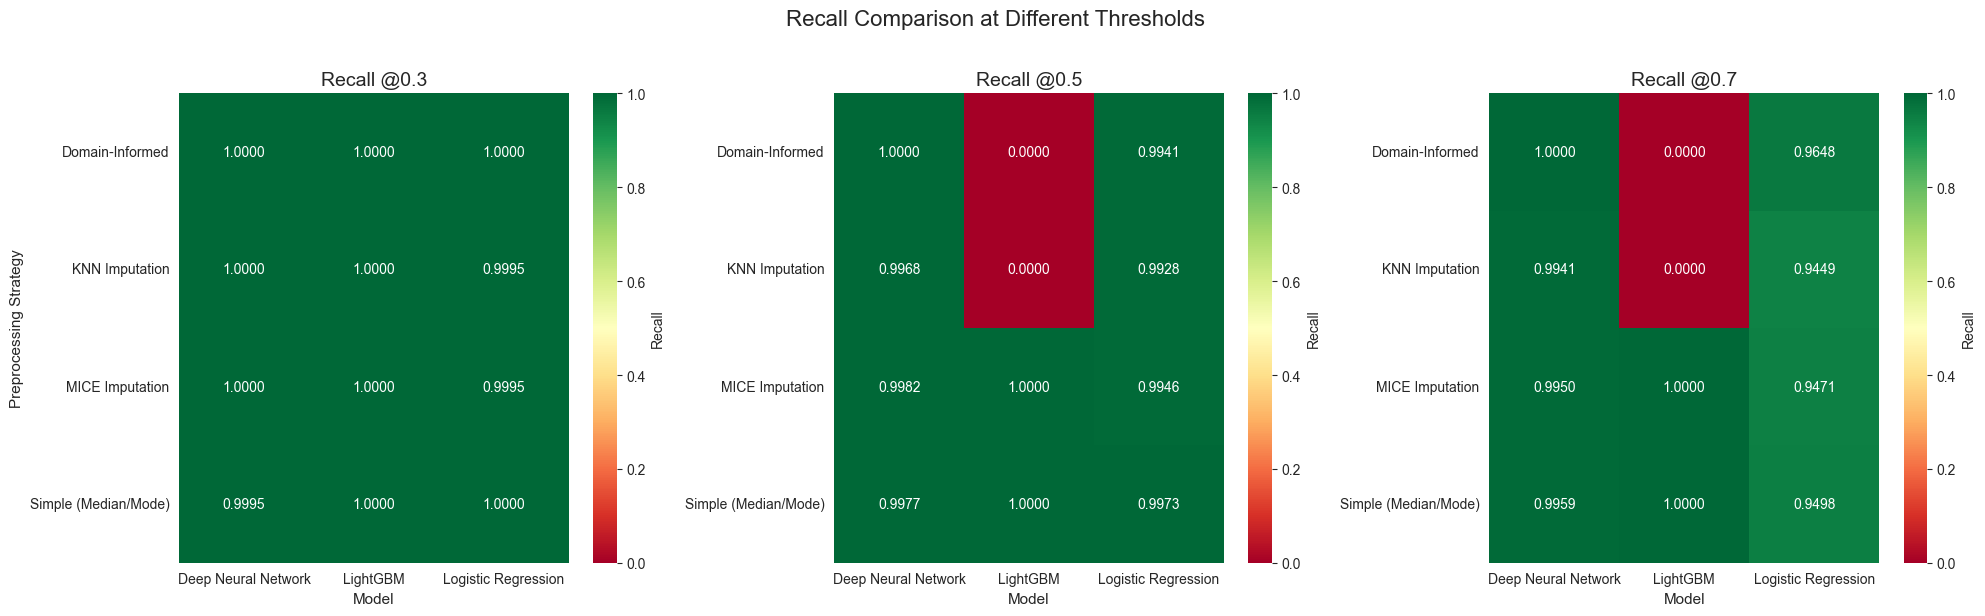

In [7]:
# Recall at different thresholds
recall_cols = ['Recall @0.3', 'Recall @0.5', 'Recall @0.7']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, recall_col in enumerate(recall_cols):
    recall_pivot = combined_results.pivot(index='Strategy', columns='Model', values=recall_col)
    
    sns.heatmap(recall_pivot, annot=True, fmt='.4f', cmap='RdYlGn',
                vmin=0, vmax=1, ax=axes[idx],
                cbar_kws={'label': 'Recall'})
    axes[idx].set_title(f'{recall_col}', fontsize=14)
    axes[idx].set_xlabel('Model', fontsize=11)
    axes[idx].set_ylabel('Preprocessing Strategy' if idx == 0 else '', fontsize=11)

plt.suptitle('Recall Comparison at Different Thresholds', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('comparison_recall_thresholds.png', dpi=300, bbox_inches='tight')
plt.show()

## 7. Model Performance by Preprocessing Strategy


AVERAGE PERFORMANCE BY PREPROCESSING STRATEGY (across all models)
                         AUROC    PR AUC  Recall (default)
Strategy                                                  
Domain-Informed       0.992553  0.977657          0.664709
KNN Imputation        0.986489  0.948954          0.663202
MICE Imputation       0.988025  0.952782          0.997590
Simple (Median/Mode)  0.989118  0.959748          0.998343


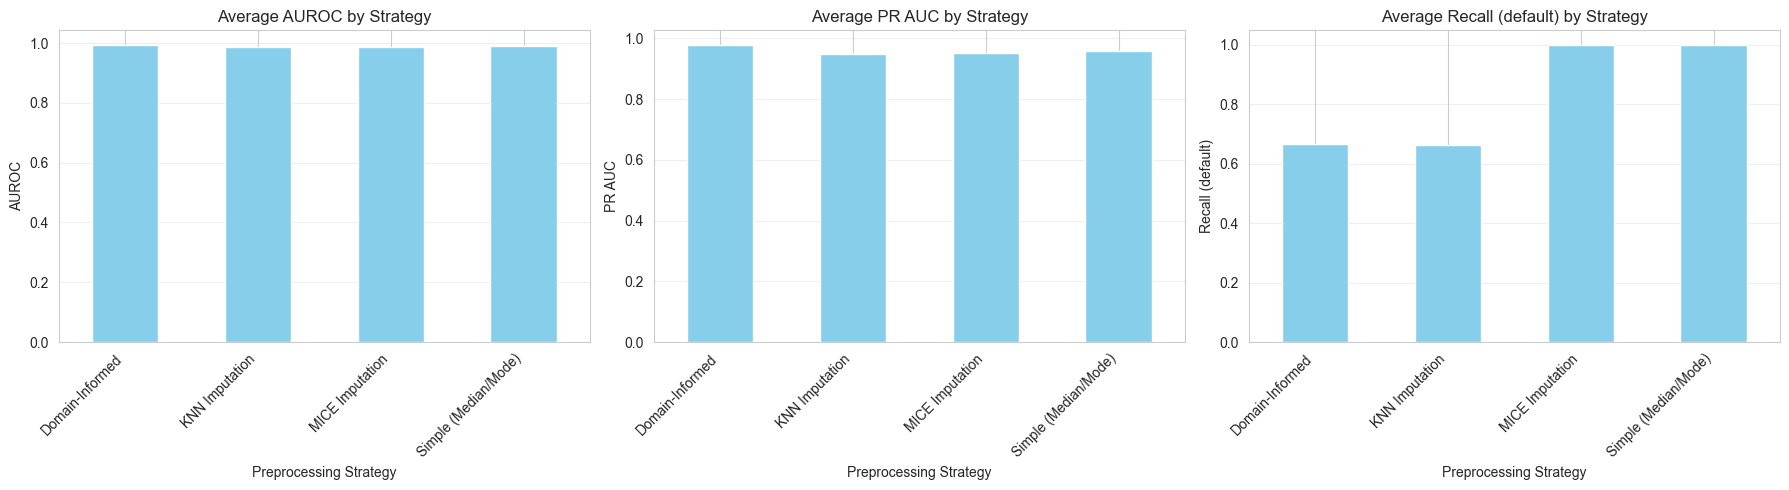

In [8]:
# Average performance by preprocessing strategy
strategy_avg = combined_results.groupby('Strategy')[['AUROC', 'PR AUC', 'Recall (default)']].mean()

print("\n" + "="*70)
print("AVERAGE PERFORMANCE BY PREPROCESSING STRATEGY (across all models)")
print("="*70)
print(strategy_avg.to_string())
print("="*70)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['AUROC', 'PR AUC', 'Recall (default)']
for idx, metric in enumerate(metrics_to_plot):
    strategy_avg[metric].plot(kind='bar', ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'Average {metric} by Strategy', fontsize=12)
    axes[idx].set_xlabel('Preprocessing Strategy')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_by_strategy.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Model Performance Comparison (average across strategies)


AVERAGE PERFORMANCE BY MODEL (across all preprocessing strategies)
                        AUROC    PR AUC  Recall (default)
Model                                                    
Deep Neural Network  0.996724  0.989481          0.998192
LightGBM             0.999762  0.999222          0.500000
Logistic Regression  0.970653  0.890652          0.994690


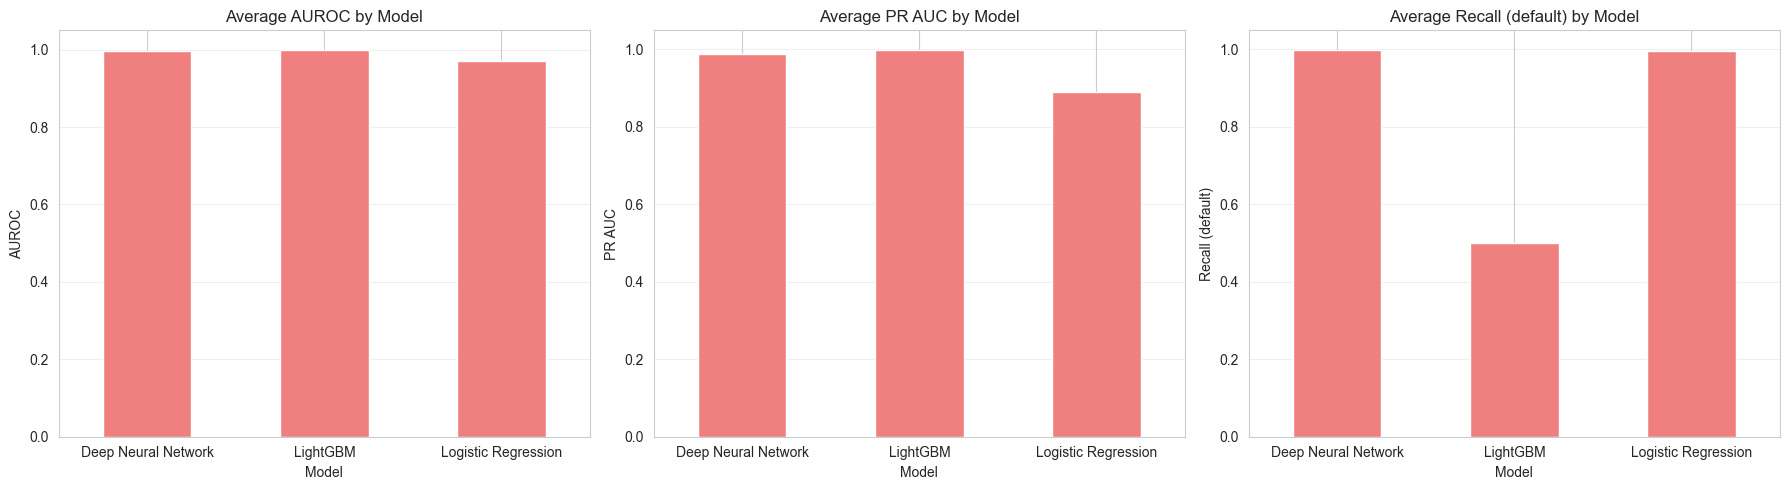

In [9]:
# Average performance by model
model_avg = combined_results.groupby('Model')[['AUROC', 'PR AUC', 'Recall (default)']].mean()

print("\n" + "="*70)
print("AVERAGE PERFORMANCE BY MODEL (across all preprocessing strategies)")
print("="*70)
print(model_avg.to_string())
print("="*70)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, metric in enumerate(metrics_to_plot):
    model_avg[metric].plot(kind='bar', ax=axes[idx], color='lightcoral')
    axes[idx].set_title(f'Average {metric} by Model', fontsize=12)
    axes[idx].set_xlabel('Model')
    axes[idx].set_ylabel(metric)
    axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=0)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_by_model.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Radar Chart - Multi-metric Comparison

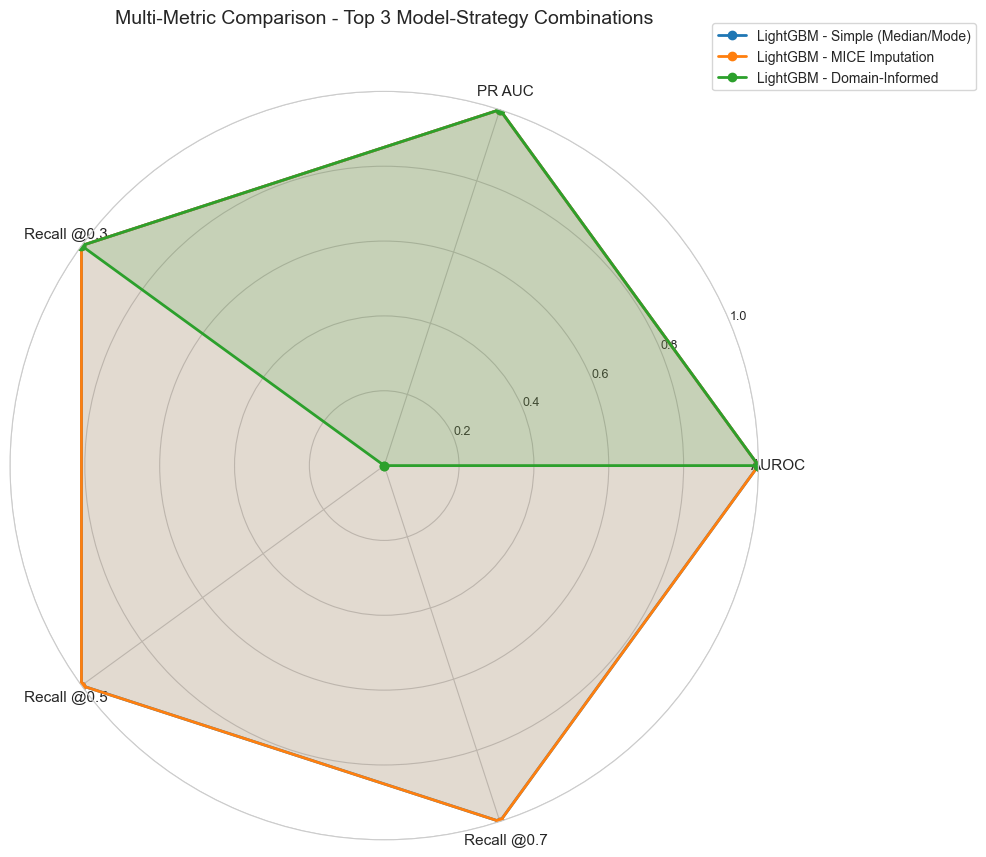

In [10]:
from math import pi

# Select top 3 model-strategy combinations by AUROC for radar chart
top_3 = combined_results.nlargest(3, 'AUROC')

categories = ['AUROC', 'PR AUC', 'Recall @0.3', 'Recall @0.5', 'Recall @0.7']
N = len(categories)

# Create radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, (_, row) in enumerate(top_3.iterrows()):
    values = [row[cat] for cat in categories]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=f"{row['Model']} - {row['Strategy']}", 
            color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=9)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.set_title('Multi-Metric Comparison - Top 3 Model-Strategy Combinations', 
             size=14, y=1.08)

plt.tight_layout()
plt.savefig('comparison_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Statistical Summary

In [11]:
print("\n" + "="*90)
print("STATISTICAL SUMMARY")
print("="*90)

summary_stats = combined_results[['AUROC', 'PR AUC', 'Recall (default)']].describe()
print("\nDescriptive Statistics (all models and strategies):")
print(summary_stats.to_string())

print("\n" + "-"*90)
print("Performance Variability:")
print("-"*90)
print(f"AUROC - Range: {combined_results['AUROC'].max() - combined_results['AUROC'].min():.4f}")
print(f"AUROC - Std Dev: {combined_results['AUROC'].std():.4f}")
print(f"\nPR AUC - Range: {combined_results['PR AUC'].max() - combined_results['PR AUC'].min():.4f}")
print(f"PR AUC - Std Dev: {combined_results['PR AUC'].std():.4f}")
print(f"\nRecall - Range: {combined_results['Recall (default)'].max() - combined_results['Recall (default)'].min():.4f}")
print(f"Recall - Std Dev: {combined_results['Recall (default)'].std():.4f}")

print("\n" + "="*90)


STATISTICAL SUMMARY

Descriptive Statistics (all models and strategies):
           AUROC     PR AUC  Recall (default)
count  12.000000  12.000000         12.000000
mean    0.989046   0.959785          0.830961
std     0.014008   0.053966          0.388148
min     0.965537   0.867804          0.000000
25%     0.976735   0.924451          0.993787
50%     0.996605   0.989635          0.997063
75%     0.999285   0.997667          0.998644
max     1.000000   1.000000          1.000000

------------------------------------------------------------------------------------------
Performance Variability:
------------------------------------------------------------------------------------------
AUROC - Range: 0.0345
AUROC - Std Dev: 0.0140

PR AUC - Range: 0.1322
PR AUC - Std Dev: 0.0540

Recall - Range: 1.0000
Recall - Std Dev: 0.3881



## 11. Recommendations

In [12]:
# Find overall best model
best_overall = combined_results.loc[combined_results['AUROC'].idxmax()]

# Find best per category
best_auroc = combined_results.loc[combined_results['AUROC'].idxmax()]
best_pr_auc = combined_results.loc[combined_results['PR AUC'].idxmax()]
best_recall = combined_results.loc[combined_results['Recall (default)'].idxmax()]

print("\n" + "="*90)
print("RECOMMENDATIONS")
print("="*90)

print("\n1. BEST OVERALL MODEL (by AUROC):")
print(f"   Model: {best_overall['Model']}")
print(f"   Preprocessing: {best_overall['Strategy']}")
print(f"   AUROC: {best_overall['AUROC']:.4f}")
print(f"   PR AUC: {best_overall['PR AUC']:.4f}")
print(f"   Recall: {best_overall['Recall (default)']:.4f}")

print("\n2. BEST FOR DISCRIMINATION (AUROC):")
print(f"   {best_auroc['Model']} with {best_auroc['Strategy']}")
print(f"   AUROC: {best_auroc['AUROC']:.4f}")

print("\n3. BEST FOR IMBALANCED CLASSES (PR AUC):")
print(f"   {best_pr_auc['Model']} with {best_pr_auc['Strategy']}")
print(f"   PR AUC: {best_pr_auc['PR AUC']:.4f}")

print("\n4. BEST FOR RECALL (Sensitivity):")
print(f"   {best_recall['Model']} with {best_recall['Strategy']}")
print(f"   Recall: {best_recall['Recall (default)']:.4f}")

print("\n5. PREPROCESSING STRATEGY INSIGHTS:")
best_strategy = strategy_avg['AUROC'].idxmax()
print(f"   Best overall strategy: {best_strategy}")
print(f"   Average AUROC: {strategy_avg.loc[best_strategy, 'AUROC']:.4f}")

print("\n6. MODEL COMPLEXITY vs PERFORMANCE:")
best_model = model_avg['AUROC'].idxmax()
print(f"   Best performing model type: {best_model}")
print(f"   Average AUROC: {model_avg.loc[best_model, 'AUROC']:.4f}")

# Clinical recommendations
print("\n7. CLINICAL DEPLOYMENT RECOMMENDATIONS:")
print("   a) For maximum accuracy: Use the best overall model")
print("   b) For interpretability: Use Logistic Regression")
print("   c) For handling missing data: Consider domain-informed preprocessing")
print("   d) For production speed: Consider LightGBM (fast inference)")
print("   e) For capturing complex patterns: Consider Deep Neural Networks")

print("\n" + "="*90)


RECOMMENDATIONS

1. BEST OVERALL MODEL (by AUROC):
   Model: LightGBM
   Preprocessing: Simple (Median/Mode)
   AUROC: 1.0000
   PR AUC: 1.0000
   Recall: 1.0000

2. BEST FOR DISCRIMINATION (AUROC):
   LightGBM with Simple (Median/Mode)
   AUROC: 1.0000

3. BEST FOR IMBALANCED CLASSES (PR AUC):
   LightGBM with Simple (Median/Mode)
   PR AUC: 1.0000

4. BEST FOR RECALL (Sensitivity):
   LightGBM with Simple (Median/Mode)
   Recall: 1.0000

5. PREPROCESSING STRATEGY INSIGHTS:
   Best overall strategy: Domain-Informed
   Average AUROC: 0.9926

6. MODEL COMPLEXITY vs PERFORMANCE:
   Best performing model type: LightGBM
   Average AUROC: 0.9998

7. CLINICAL DEPLOYMENT RECOMMENDATIONS:
   a) For maximum accuracy: Use the best overall model
   b) For interpretability: Use Logistic Regression
   c) For handling missing data: Consider domain-informed preprocessing
   d) For production speed: Consider LightGBM (fast inference)
   e) For capturing complex patterns: Consider Deep Neural Networks

## 12. Save Comprehensive Results

In [13]:
# Save combined results
combined_results.to_csv('model_results/comprehensive_comparison.csv', index=False)

# Save summary statistics
strategy_avg.to_csv('model_results/performance_by_strategy.csv')
model_avg.to_csv('model_results/performance_by_model.csv')

# Save best performers
best_performers_df.to_csv('model_results/best_performers_by_metric.csv', index=False)

# Create summary report
summary_report = {
    'Best Overall': {
        'Model': best_overall['Model'],
        'Strategy': best_overall['Strategy'],
        'AUROC': best_overall['AUROC'],
        'PR AUC': best_overall['PR AUC'],
        'Recall': best_overall['Recall (default)']
    },
    'Best AUROC': {
        'Model': best_auroc['Model'],
        'Strategy': best_auroc['Strategy'],
        'Score': best_auroc['AUROC']
    },
    'Best PR AUC': {
        'Model': best_pr_auc['Model'],
        'Strategy': best_pr_auc['Strategy'],
        'Score': best_pr_auc['PR AUC']
    },
    'Best Recall': {
        'Model': best_recall['Model'],
        'Strategy': best_recall['Strategy'],
        'Score': best_recall['Recall (default)']
    },
    'Best Strategy': best_strategy,
    'Best Model Type': best_model
}

import json
with open('model_results/summary_report.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print("All comparison results saved to 'model_results/' directory")
print("\nFiles saved:")
print("  - comprehensive_comparison.csv")
print("  - performance_by_strategy.csv")
print("  - performance_by_model.csv")
print("  - best_performers_by_metric.csv")
print("  - summary_report.json")
print("\nVisualizations saved as PNG files in the main directory")

All comparison results saved to 'model_results/' directory

Files saved:
  - comprehensive_comparison.csv
  - performance_by_strategy.csv
  - performance_by_model.csv
  - best_performers_by_metric.csv
  - summary_report.json

Visualizations saved as PNG files in the main directory


## Summary

This comprehensive comparison analyzed:
- **3 Model Types**: Logistic Regression, LightGBM, Deep Neural Network
- **4 Preprocessing Strategies**: Simple, KNN, MICE, Domain-Informed
- **Total Combinations**: 12 model-strategy pairs

### Key Metrics Evaluated:
1. **AUROC** (Area Under ROC Curve) - Overall discrimination ability
2. **PR AUC** (Precision-Recall AUC) - Performance on imbalanced classes
3. **Recall** at multiple thresholds - Sensitivity to positive cases

### Clinical Relevance:
- High AUROC indicates good separation between suppressed and non-suppressed patients
- High PR AUC is critical for imbalanced medical datasets
- Recall metrics show ability to identify patients needing intervention

### Next Steps:
1. Select best model for deployment based on clinical priorities
2. Perform external validation if additional data available
3. Conduct feature importance analysis for clinical interpretability
4. Consider ensemble methods combining top performers
5. Calibrate probability predictions for clinical decision-making